<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import direct_sparse_layer_definition as ld
import sparse_tools as sp

import models.modelnet as model
from utils.scannet_dataset import ScanNetDataset

%matplotlib inline

Using TensorFlow backend.


In [3]:
SCANNET_PATH = '/scratch3/scannet/scans/'
ds = ScanNetDataset(SCANNET_PATH, res=256, split=True, save_preloads=None)

In [4]:
res = 256
BATCH_SIZE = 10
tensor_in_sizes = np.array([BATCH_SIZE, res, res, res, 1]) #[batch, depth, height, width, in_channels]

num_classes = ds.get_num_classes()
print("number of classes", num_classes)
batch_label_sizes = [BATCH_SIZE, num_classes]
max_epochs = 1000
dim = 5
regularizer = None
initializer = tf.truncated_normal_initializer(0, 0.1)
    
sparse_data = tf.sparse_placeholder(tf.float32, shape=tensor_in_sizes, name="sparse_placeholder")
dense_labels = tf.placeholder(tf.float32, shape=batch_label_sizes, name="labels_placeholder")

net, ops = model.build_256(sparse_data, tensor_in_sizes, num_classes=num_classes,
    scope='sn256-',
    initializer=initializer,
    regularizer=regularizer,
    d1=0.01,
    d2=0.03,
    d3=0.07
)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=net['dense2'], labels=dense_labels, name='softmax_loss'))
correct_prediction = tf.equal(tf.argmax(net['dense2'], 1), tf.argmax(dense_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
total_correct = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

('number of classes', 21)


In [5]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdagradOptimizer(learning_rate)
train_op = optimizer.minimize(loss, global_step=None)

sess = tf.Session()
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

[None, None]

In [6]:
NUM_EPOCHS = 10000
for epoch in range(1, 1 + NUM_EPOCHS):
    t0 = time.time()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    num_train_batches = 0
    num_val_batches = 0
    
    for batch in ds.iterate_minibatches(BATCH_SIZE, 'train'):
#         if len(batch[3]) != BATCH_SIZE:
#             break

        num_train_batches += 1
        feed_dict={sparse_data: tf.SparseTensorValue(batch[0], batch[1], batch[2]), dense_labels: batch[3]}
        _, l_value, correct_value = sess.run([train_op, loss, total_correct], feed_dict=feed_dict)
        train_loss += l_value
        train_acc += correct_value
    t1 = time.time()

    print('Epoch {} of {} took {:.3f}s'.format(epoch, NUM_EPOCHS, t1 - t0))
    print('  train loss    :\t\t{:.6f}'.format(train_loss / num_train_batches))
    print('  train accu    :\t\t{:.6f}'.format(train_acc / num_train_batches / BATCH_SIZE))
    
    if epoch % 10 == 0:
        for batch in ds.iterate_minibatches(BATCH_SIZE, 'val', shuffle=False, angle=None):
#             if len(batch[3]) != BATCH_SIZE:
#                 break

            num_val_batches += 1
            feed_dict={sparse_data: tf.SparseTensorValue(batch[0], batch[1], batch[2]), dense_labels: batch[3]}
            l_value, correct_value = sess.run([loss, total_correct], feed_dict=feed_dict)
            val_loss += l_value
            val_acc += correct_value
        print('  val loss    :\t\t{:.6f}'.format(val_loss / num_val_batches))
        print('  val accu    :\t\t{:.6f}'.format(val_acc / num_val_batches / BATCH_SIZE))

Epoch 1 of 10000 took 42.655s
  train loss    :		1839.797852
  train accu    :		0.200000
Epoch 2 of 10000 took 52.261s
  train loss    :		6294758.500000
  train accu    :		0.100000
Epoch 3 of 10000 took 45.848s
  train loss    :		1855.794189
  train accu    :		0.100000
Epoch 4 of 10000 took 41.596s
  train loss    :		364.985748
  train accu    :		0.100000
Epoch 5 of 10000 took 46.512s
  train loss    :		237.286407
  train accu    :		0.100000
Epoch 6 of 10000 took 55.504s
  train loss    :		76.800797
  train accu    :		0.000000
Epoch 7 of 10000 took 52.139s
  train loss    :		17.378174
  train accu    :		0.000000
Epoch 8 of 10000 took 45.079s
  train loss    :		5.340543
  train accu    :		0.100000
Epoch 9 of 10000 took 50.802s
  train loss    :		11.032443
  train accu    :		0.100000
Epoch 10 of 10000 took 51.199s
  train loss    :		20.176855
  train accu    :		0.000000
  val loss    :		3.471151
  val accu    :		0.005263
Epoch 11 of 10000 took 53.355s
  train loss    :		33.735607
  train

KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES), max_to_keep=100)

In [ ]:
saver.restore(sess, '../data/data')

In [ ]:
saver.save(sess, '../data/data')

In [ ]:
points = ds.get_data('/scratch3/scannet/scans/scene0000_00/scene0000_00_vh_clean.ply')

In [ ]:
for batch1 in ds.iterate_minibatches(BATCH_SIZE, 'train'):
#         if len(batch[3]) != BATCH_SIZE:
#             break

    break
    
for batch2 in ds.iterate_minibatches(BATCH_SIZE, 'train'):
#         if len(batch[3]) != BATCH_SIZE:
#             break

    break

In [ ]:
feed_dict={sparse_data: tf.SparseTensorValue(batch1[0], batch1[1], batch1[2]), dense_labels: batch1[3]}

In [ ]:
tf.global_variables()[4]

In [ ]:
sess.run(tf.global_variables()[4])

In [ ]:
sess.run(net['conv6_1'], feed_dict=feed_dict)

In [ ]:
sess.run([train_op, loss, total_correct], feed_dict=feed_dict)

In [ ]:
for k, v in ds.data_locs.items():
    print(len(v))

In [7]:
answers = []
labels = []
for batch in ds.iterate_minibatches(10, 'train', shuffle=True, angle=-1):
    feed_dict={sparse_data: tf.SparseTensorValue(batch[0], batch[1], batch[2]), dense_labels: batch[3]}
    answers.append(sess.run(net['dense2'], feed_dict=feed_dict))
    labels.append(batch[3])
    print(len(batch[-1]))

10


In [8]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [9]:
raveled_answers = np.concatenate(answers, axis=0)
raveled_answers

array([[  3.20965230e-01,   1.84494197e+00,  -1.56522304e-01,
          8.25557411e-01,   1.35505855e+00,  -1.35855484e+00,
          9.33725238e-01,  -1.08439684e+00,   1.07906389e+00,
          7.79269266e+00,  -6.83656693e-01,  -1.24655098e-01,
          9.84490156e-01,  -1.88227907e-01,   1.05177796e+00,
          1.06670439e+00,  -1.26054204e+00,   1.06478906e+00,
         -5.21879435e-01,  -4.16793585e-01,  -9.10377026e-01],
       [  2.62429342e-02,   7.43044257e-01,   5.34014702e-02,
          1.01236120e-01,   1.19379751e-01,  -5.65361619e-01,
          1.43762469e-01,  -3.76609176e-01,   2.93226182e-01,
          2.80344772e+00,  -2.41559148e-01,   2.24326164e-01,
          6.70267463e-01,  -4.21327446e-03,   4.57224786e-01,
          3.99236083e-01,  -4.58180636e-01,   4.66359675e-01,
         -2.14010149e-01,  -1.20179266e-01,  -3.29496384e-01],
       [ -1.55723423e-01,  -5.78593254e-01,   8.72040540e-03,
         -6.32367551e-01,  -1.16319454e+00,   1.95551902e-01,
      

In [10]:
softmax(raveled_answers)

array([[  1.68269962e-01,   3.77221912e-01,   7.15167522e-02,
          2.77326137e-01,   3.94027978e-01,   3.09101865e-03,
          2.99753189e-01,   3.20923980e-03,   2.92367041e-01,
          8.87184799e-01,   1.56313032e-02,   3.40631120e-02,
          2.05337331e-01,   6.09101616e-02,   2.67965585e-01,
          2.81884640e-01,   1.17414515e-03,   2.38813445e-01,
          3.04954555e-02,   3.59994657e-02,   5.94692770e-03],
       [  1.25317067e-01,   1.25328213e-01,   8.82219151e-02,
          1.34407103e-01,   1.14519224e-01,   6.83252001e-03,
          1.36046484e-01,   6.51313923e-03,   1.33242711e-01,
          6.04244275e-03,   2.43217815e-02,   4.82886396e-02,
          1.49969488e-01,   7.32160658e-02,   1.47865877e-01,
          1.44608453e-01,   2.61928607e-03,   1.31269574e-01,
          4.14897986e-02,   4.84299473e-02,   1.06308041e-02],
       [  1.04467995e-01,   3.34247909e-02,   8.43668357e-02,
          6.45389780e-02,   3.17587741e-02,   1.46231661e-02,
      

In [11]:
predicted = np.argmax(softmax(np.concatenate(answers, axis=0)), axis=1)

In [12]:
true = np.argmax(np.concatenate(labels, 0), 1).ravel()

In [13]:
recall = np.zeros(21)

for i in range(21):
    recall[i] = ((predicted == i) * (true == i)).sum() / float((predicted == i).sum()) if (predicted == i).sum() > 0 else 0

In [14]:
recall

array([ 0.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ])

(array([ 2.,  4.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([  0. ,   1.6,   3.2,   4.8,   6.4,   8. ,   9.6,  11.2,  12.8,
         14.4,  16. ]),
 <a list of 10 Patch objects>)

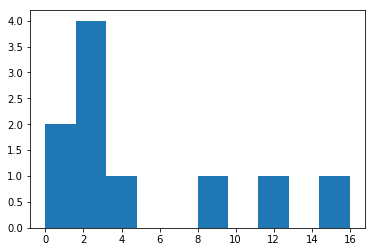

In [15]:
plt.hist(np.argmax(softmax(np.concatenate(answers, axis=0)), axis=1))

(array([ 1.,  0.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  2.]),
 array([  2. ,   3.7,   5.4,   7.1,   8.8,  10.5,  12.2,  13.9,  15.6,
         17.3,  19. ]),
 <a list of 10 Patch objects>)

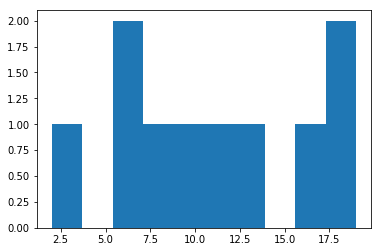

In [16]:
plt.hist(np.argmax(np.concatenate(labels, 0), 1).ravel())

In [17]:
labels

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        

In [18]:
softmax(raveled_answers)

array([[  1.68269962e-01,   3.77221912e-01,   7.15167522e-02,
          2.77326137e-01,   3.94027978e-01,   3.09101865e-03,
          2.99753189e-01,   3.20923980e-03,   2.92367041e-01,
          8.87184799e-01,   1.56313032e-02,   3.40631120e-02,
          2.05337331e-01,   6.09101616e-02,   2.67965585e-01,
          2.81884640e-01,   1.17414515e-03,   2.38813445e-01,
          3.04954555e-02,   3.59994657e-02,   5.94692770e-03],
       [  1.25317067e-01,   1.25328213e-01,   8.82219151e-02,
          1.34407103e-01,   1.14519224e-01,   6.83252001e-03,
          1.36046484e-01,   6.51313923e-03,   1.33242711e-01,
          6.04244275e-03,   2.43217815e-02,   4.82886396e-02,
          1.49969488e-01,   7.32160658e-02,   1.47865877e-01,
          1.44608453e-01,   2.61928607e-03,   1.31269574e-01,
          4.14897986e-02,   4.84299473e-02,   1.06308041e-02],
       [  1.04467995e-01,   3.34247909e-02,   8.43668357e-02,
          6.45389780e-02,   3.17587741e-02,   1.46231661e-02,
      